In [1]:
from extract import SocialETL, construct_query_for_twarc, extract_tags, SocialDB, UserETL
import hashtags as h
import hashtags_readcsv as r_csv
import pandas as pd
import numpy as np
import json
import statistics
import networkx as nx

# 1) Download DF

In [ ]:
#modifiche: cambiare data e togliere lang eng
m = SocialETL(query="(#covid OR #pridemonth OR #grammys OR #justiceforjohnnydepp OR #putin OR #russia OR #ukraine OR #war)", pages=5, recent=False) #strangerthings4 

## creazione df_base

In [ ]:
user_id=m.df['author_id'] 
set_user=set(user_id)
#un utente può aver fatto più di un tweet, in questo modo andiamo a vedere i suoi ultimi tweet solo una volta.
print(len(set_user))

In [ ]:
hashtag_for_user={}
tweet_for_user={}
retweet_for_user={}
conversation_for_user={}
verified_for_user={}
location_for_user={}

for e in set_user:                                                             #1 pages=20 tweet   
    u=UserETL(e,pages=1)                                                       #aggiungere più pagine (1pag=20)
    #preprocessing hashtag
    u.df=u.df.dropna(subset=['entities.hashtags'])                             #drop nan values on column hashtags
    u.df.reset_index()
    u.df['entities.hashtags']=u.df['entities.hashtags'].apply(eval)            #convert into dict
    u.df["entities.hashtags"] = u.df["entities.hashtags"].map(h.extract_tags)  #extract tags
    hashtag_for_user[e]=u.df["entities.hashtags"].tolist()                     #convert pandas series into a list
    #preprocessing other attributes
    u.df=u.df.dropna(subset=['retweeted_user_id'])
    retweet_for_user[e]=u.df['retweeted_user_id'].tolist()
    conversation_for_user[e]=u.df['conversation_id'].tolist()
    tweet_for_user[e]=u.df['id'].tolist() 
    location_for_user[e]=u.df['author.location'].tolist()
    verified_for_user[e]=u.df['author.verified']

In [ ]:
user_id=[]
tweet_id=[]
hashtag=[]
retweet=[]
location=[]
verified=[]
conversation=[]
for u,h in hashtag_for_user.items():
    user_id.append(u)
    hashtag.append(h)
for u,t in tweet_for_user.items():
    tweet_id.append(t)
for u,r in retweet_for_user.items():
    retweet.append(r)
for u,l in location_for_user.items():
    location.append(l)
for u,v in verified_for_user.items():
    verified.append(v)
for u,c in conversation_for_user.items():
    conversation.append(c)

In [ ]:
loc=[]
for lists in location:
    nest_loc=[]
    for el in lists:  
        if isinstance(el,float):
            nest_loc.append(0) #remove nan locations
        elif isinstance(el,str):
            nest_loc.append(statistics.mode(lists)) #set as locaton the most used one
    loc.append(nest_loc)


In [ ]:
#create a pandas dataframe
df_1=pd.DataFrame({"user_id":user_id,
                       'tweet_id':tweet_id,
                      'retweet_id': retweet,
                       'conversation_id':conversation,
                      "hashtag":hashtag,
                     'location':loc,
                     'verified':verified})

In [ ]:
#df_1.to_csv('df_1')
df_1=pd.read_csv('df_1')
#codici per prova csv
#df_nodes['hashtag']=df_nodes['hashtag'].apply(eval)
#df_nodes['tweet_id']=df_nodes['tweet_id'].apply(eval)
df_1['retweet_id']=df_1['retweet_id'].apply(eval)

# creazione df da retweet df_1

In [ ]:
user_id=df_1['retweet_id']
user_ret=set()
for e in df_1['retweet_id']:
    for e_nested in e:
        user_ret.add(e_nested)
print(len(user_ret))

In [ ]:
#estarre pure retweeted_user_id per edge
hashtag_for_user_ret={}
tweet_for_user_ret={}
retweet_for_user_ret={}
conversation_for_user_ret={}
verified_for_user_ret={}
location_for_user_ret={}

for e in user_ret:                                                             #1 pages=20 tweet   
    u=UserETL(e,pages=1)                                                       #aggiungere più pagine (1pag=20)
    #preprocessing hashtag
    u.df=u.df.dropna(subset=['entities.hashtags'])                             #drop nan values on column hashtags
    u.df.reset_index()
    #print(u.df['entities.hashtags'])
    u.df['entities.hashtags']=u.df['entities.hashtags'].apply(eval)            #convert into dict
    u.df["entities.hashtags"] =u.df["entities.hashtags"].map(h.extract_tags)  #extract tags
    hashtag_for_user_ret[e]=u.df["entities.hashtags"].tolist()                     #convert pandas series into a list
    #preprocessing other attributes
    u.df=u.df.dropna(subset=['retweeted_user_id'])
    retweet_for_user_ret[e]=u.df['retweeted_user_id'].tolist()
    conversation_for_user_ret[e]=u.df['conversation_id'].tolist()
    tweet_for_user_ret[e]=u.df['id'].tolist() 
    location_for_user_ret[e]=u.df['author.location'].tolist()
    verified_for_user_ret[e]=u.df['author.verified']

In [ ]:
user_id_ret=[]
tweet_id_ret=[]
hashtag_ret=[]
retweet_ret=[]
location_ret=[]
verified_ret=[]
conversation_ret=[]
for u,h in hashtag_for_user_ret.items():
    user_id_ret.append(u)
    hashtag_ret.append(h)
for u,t in tweet_for_user_ret.items():
    tweet_id_ret.append(t)
for u,r in retweet_for_user_ret.items():
    retweet_ret.append(r)
for u,l in location_for_user_ret.items():
    location_ret.append(l)
for u,v in verified_for_user_ret.items():
    verified_ret.append(v)
for u,c in conversation_for_user_ret.items():
    conversation_ret.append(c)
loc=[]
for lists in location_ret:
    nest_loc=[]
    for el in lists:  
        if isinstance(el,float):
            nest_loc.append(0) #remove nan locations
        elif isinstance(el,str):
            nest_loc.append(statistics.mode(lists)) #set as locaton the most used one
    loc.append(nest_loc)
#create a pandas dataframe


In [ ]:
df_2=pd.DataFrame({"user_id":user_id_ret,
                       'tweet_id':tweet_id_ret,
                      'retweet_id': retweet_ret,
                       'conversation_id':conversation_ret,
                      "hashtag":hashtag_ret,
                     'location':loc,
                     'verified':verified_ret})
df_2

In [ ]:
df_2.to_csv('df_2')

# creazione df da retweet df_2

In [2]:
df_2=pd.read_csv('df_2')
df_2['retweet_id']=df_2['retweet_id'].apply(eval)

In [3]:
#user_id=df_2['retweet_id']
user_ret=set()
for e in df_2['retweet_id']:
    for e_nested in e:
        user_ret.add(e_nested)
print(len(user_ret))

501


In [4]:
hashtag_for_user={}
tweet_for_user={}
retweet_for_user={}
conversation_for_user={}
verified_for_user={}
location_for_user={}

for e in user_ret:                                                             #1 pages=20 tweet   
    u=UserETL(e,pages=1)                                                       #aggiungere più pagine (1pag=20)
    #preprocessing hashtag
    u.df=u.df.dropna(subset=['entities.hashtags'])                             #drop nan values on column hashtags
    u.df.reset_index()
    u.df['entities.hashtags']=u.df['entities.hashtags'].apply(eval)            #convert into dict
    u.df["entities.hashtags"] = u.df["entities.hashtags"].map(h.extract_tags)  #extract tags
    hashtag_for_user[e]=u.df["entities.hashtags"].tolist()                     #convert pandas series into a list
    #preprocessing other attributes
    u.df=u.df.dropna(subset=['retweeted_user_id'])
    retweet_for_user[e]=u.df['retweeted_user_id'].tolist()
    conversation_for_user[e]=u.df['conversation_id'].tolist()
    tweet_for_user[e]=u.df['id'].tolist() 
    location_for_user[e]=u.df['author.location'].tolist()
    verified_for_user[e]=u.df['author.verified']

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

UnboundLocalError: local variable 'df' referenced before assignment

In [5]:
user_id=[]
tweet_id=[]
hashtag=[]
retweet=[]
location=[]
verified=[]
conversation=[]
for u,h in hashtag_for_user.items():
    user_id.append(u)
    hashtag.append(h)
for u,t in tweet_for_user.items():
    tweet_id.append(t)
for u,r in retweet_for_user.items():
    retweet.append(r)
for u,l in location_for_user.items():
    location.append(l)
for u,v in verified_for_user.items():
    verified.append(v)
for u,c in conversation_for_user.items():
    conversation.append(c)
loc=[]
for lists in location:
    nest_loc=[]
    for el in lists:  
        if isinstance(el,float):
            nest_loc.append(0) #remove nan locations
        elif isinstance(el,str):
            nest_loc.append(statistics.mode(lists)) #set as locaton the most used one
    loc.append(nest_loc)

In [6]:
#create a pandas dataframe
df_3=pd.DataFrame({"user_id":user_id,
                       'tweet_id':tweet_id,
                      'retweet_id': retweet,
                       'conversation_id':conversation,
                      "hashtag":hashtag,
                     'location':loc,
                     'verified':verified})
df_3.shape

(358, 7)

In [7]:
df_3.to_csv('df_3')

## creazione df finale

In [80]:
#first dataset
df_1=pd.read_csv('df_1')
del df_1['Unnamed: 0']
df_1.set_index('user_id',inplace=True)
#second dataset
df_2=pd.read_csv('df_2')
del df_2['Unnamed: 0']
df_2.set_index('user_id',inplace=True)
#third dataset
df_3=pd.read_csv('df_3')
del df_3['Unnamed: 0']
df_3.set_index('user_id',inplace=True)

In [81]:
df_nodes=pd.concat([df_1,df_2,df_3]) 
#df_nodes

In [82]:
df_nodes.shape

(1386, 6)

In [83]:
df_nodes['verified']

user_id
1490366731533099011    0    False\n1    False\n9    False\nName: auth...
1542703191283867648       1    False\nName: author.verified, dtype: bool
1356158825825525761       Series([], Name: author.verified, dtype: bool)
1096852913463414784       1    False\nName: author.verified, dtype: bool
23484619                  Series([], Name: author.verified, dtype: bool)
                                             ...                        
1504128206693150724    0    False\n1    False\n2    False\n3    False...
1195427305453162498       Series([], Name: author.verified, dtype: bool)
1461766105110831112       Series([], Name: author.verified, dtype: bool)
1506338005887422468    0    False\n2    False\n3    False\n5    False...
1430793200             1    True\n2    True\nName: author.verified, d...
Name: verified, Length: 1386, dtype: object

In [84]:
#df_nodes.to_csv('4438_users_csv')
#df_nodes=pd.read_csv('4438_users_csv')
#codici per prova csv
#df_nodes['user_id']=df_nodes['user_id'].map(eval)
df_nodes['hashtag']=df_nodes['hashtag'].map(str).apply(eval)
df_nodes['tweet_id']=df_nodes['tweet_id'].map(str).apply(eval)
df_nodes['conversation_id']=df_nodes['conversation_id'].map(str).apply(eval)
df_nodes['retweet_id']=df_nodes['retweet_id'].apply(eval)
df_nodes['location']=df_nodes['location'].map(str).apply(eval)

In [98]:
for e in df_nodes['verified']:
    print(e.split())

['0', 'False', '1', 'False', '9', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['1', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['1', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['0', 'False', '9', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['0', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['3', 'False', '6', 'False', '9', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['1', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['0', 'False', '1', 'False', '2', 'False', '3', 'False', '4', 'False', '5', 'False', '6', 'False', '7', 'False', '8', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['1', 'False', '6', 'False', 'Name:', 'author.verified,', 'dtype:', 'b

['5', 'False', '6', 'False', '7', 'False', '8', 'False', '9', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['2', 'False', '3', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['0', 'False', '1', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['1', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['0', 'False', '1', 'False', '2', 'False', '3', 'False', '4', 'False', '5', 'False', '8', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['0', 'False', '3', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['0', 'False', '4', 'False', '6', 'False', '8', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['0', 'False', '1', 'False', '6', 'False', '7', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['1', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['0', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['1', 'False', '6', 'False', 'Name:', 'author.verif

['7', 'False', '8', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['0', 'False', '6', 'False', '7', 'False', '8', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['1', 'False', '2', 'False', '3', 'False', '9', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['0', 'False', '1', 'False', '4', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['1', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['2', 'False', '3', 'False', '8', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['0', 'False', '3', 'False', '4', 'False', '5', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['6', 'False', '7', 'False', '8', 'False', '9', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['0', 'False', '1', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
[

['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['0', 'False', '2', 'False', '6', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['0', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['0', 'False', '5', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['1', 'False', '3', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['1', 'False', '2', 'False', '4', 'False', '6', 'False', '7', 'False', '8', 'False', '9', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['2', 'False', '3', 'False', '5', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['0', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['1', 'False', '2', 'False', '5', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['4', 'True', 'Name:', 'author.verified,', 'dtype:', 'bool']
['0', 'False', '1', 'False', '3', 'False', '5', 'False', '

['2', 'False', '9', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['0', 'False', '1', 'False', '8', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['0', 'False', '1', 'False', '2', 'False', '6', 'False', '7', 'False', '8', 'False', '9', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['0', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['0', 'False', '5', 'False', '8', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['3', 'False', '4', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['3', 'False', '4', 'False', '8', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['2', 'False', '7', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['0', 'False', '2', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['5', 'False', '8', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['0', 'False', '1', 'False', '4', 'False', '6', 'False', '7', 'False', '9', 'Fa

['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['5', 'False', '6', 'False', '8', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['2', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['5', 'False', '7', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['0', 'False', '6', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['6', 'True', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Ser

['1', 'False', '4', 'False', '5', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['2', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['3', 'True', '6', 'True', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['4', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['0', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['2', 'True', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['1', 'False', '3', 'False', '5', 'False', '6', 'False', '7', 'False', '8', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['8', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['1', 'False', '2', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Se

['2', 'False', '3', 'False', '4', 'False', '5', 'False', '6', 'False', '7', 'False', '8', 'False', '9', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['2', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['7', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['7', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['2', 'True', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['1', 'False', '8', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['5', 'True', '6', 'True', 'Name:', 'author.verified,', 'dtype:', 'bool']
['8', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['S

['0', 'False', '2', 'False', '3', 'False', '4', 'False', '5', 'False', '6', 'False', '7', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['1', 'False', '5', 'False', '7', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['5', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['Series(

['3', 'False', '4', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['8', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['1', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['4', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['1', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['0', 'True', '5', 'True', 'Name:', 'author.verified,', 'dtype:', 'bool']
['0', 'False', '3', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['8', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['2', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 

['0', 'False', '1', 'False', '2', 'False', '3', 'False', '4', 'False', '5', 'False', '6', 'False', '7', 'False', '8', 'False', '9', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['2', 'False', '5', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['5', 'True', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['1', 'False', '5', 'False', '8', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['9', 'True', 'Name:', 'author.verified,', 'dtype:', 'bool']
['8', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['2', 'False', '4', '

['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['0', 'False', '1', 'False', '2', 'False', '3', 'False', '4', 'False', '5', 'False', '6', 'False', '7', 'False', '8', 'False', '9', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['0', 'False', '3', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['3', 'False', '7', 'False', '8', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['2', 'False', '4', 'False', '6', 'False', '8', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['2', 'False', '5', 'False', '6', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['6', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['7', 'False', '9', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['2', 'False', '5', 'False', '6', 'False', 'Name:', 'author.ve

['0', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['3', 'True', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['0', 'False', '1', 'False', '5', 'False', '6', 'False', '7', 'False', '9', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['2', 'False', '3', 'False', '4', 'False', '5', 'False', '6', 'False', '7', 'False', '9', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['5', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['0', 'False', '1', 'False', '2', 'False', '3', 'False', '4', 'False', '5', 'False', '6', 'False', '7', 'False', '8', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['0', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['0', 'True', '4', 'True', 'Name:', 'author.verif

['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['0', 'False', '2', 'False', '3', 'False', '4', 'False', '5', 'False', '7', 'False', '8', 'False', '9', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['2', 'False', '5', 'False', '7', 'False', '8', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['2', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['Series([],', 'Name:', 'author.verified,', 'dtype:', 'bool)']
['2', 'False', '4', 'False', '6', 'False', '8', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['0', 'False', '1', 'False', '2', 'False', '3', 'False', '4', 'False', '5', 'False', '6', 'False', '8', 'False', '9', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['0', 'False', '1', 'False', '4', 'False', '7', 'False', '8', 'False', '9', 'False', 'Name:', 'author.verified,', 'dtype:', 'bool']
['8', 'False

In [97]:
df_nodes['verified']=df_nodes['verified'].map(eval)

SyntaxError: invalid syntax (<string>, line 1)

In [95]:
for l in df_nodes['verified']:
    if 'True' in l:
        l=True
    else:
        l=False
df_nodes['verified'].value_counts()

False    1386
Name: verified_b, dtype: int64

## preprocessing 

In [38]:
#convert nested lists on set
def to_sets(nested_lists): 
    outer_list = set()
    for el in nested_lists: 
        if type(el) == list: 
            outer_list.update(el) 
        else: 
            outer_list.add(el)
    return outer_list
#nested_list=[['onepiece', 'onepiecefilmred'], ['dbacks']]

In [39]:
df_nodes['hashtag']=df_nodes['hashtag'].map(to_sets)
df_nodes['tweet_id']=df_nodes['tweet_id'].map(to_sets)
df_nodes['conversation_id']=df_nodes['conversation_id'].map(to_sets)
df_nodes['retweet_id']=df_nodes['retweet_id'].map(to_sets)
df_nodes['verified']=df_nodes['verified'].map(to_sets)
df_nodes['location']=df_nodes['location'].map(to_sets)

In [40]:
df_nodes.head(3)

,tweet_id,retweet_id,conversation_id,hashtag,location,verified
user_id,,,,,,
1490366731533099011,"{1557478927559524353, 1557478994831982593, 155...","{1548658198109896707, 838012831530352640, 1449...","{1557478927559524353, 1557478994831982593, 155...","{perronne, ukraine, piste}",{France},"{., \n, h, d, u, l, , r, m, a, e, t, y, 9, i,..."
1542703191283867648,{1557479333681401857},{1450867630496264197},{1557479333681401857},{justiceforjohnnydepp},{at a concert},"{., \n, h, d, u, l, , r, m, a, e, t, y, i, ,,..."
1356158825825525761,{},{},{},{ukraine},{},"{., ), h, d, S, u, [, l, , r, m, a, e, t, y, ..."


# 2) Categorizzazione utenti

In [41]:
with open('hashtags_300.json', 'r') as f:
    my_dict = json.load(f)

In [42]:
proukr=set()
prorus=set()
pax=set()
for k,v in my_dict.items():
    for e in v:
        if k=='proukr':
            proukr.update(e)
        elif k=='pax':
            pax.update(e)
        elif k=='prorus':
            prorus.update(e)

In [43]:
cat=set.union(proukr,prorus,pax)
count1=0
count4=0
index1=[]
index4=[]

for i, row in enumerate(df_nodes['hashtag']): 
    if row.intersection(cat)==set():#no intersezione   
        #print(row.intersectionn(cat))
        #print("l'utente {}  appartiene alla 4 categoria".format(row.intersection(cat)))
        #print("4 categoria", row)
        count4 += 1
        index4.append(df_nodes.index[i])
        
    else: #c'è intersezione: uno della 3 categorie
        #print("non è la 4 categoria perchè contiene",row.intersection(cat))
       # if row.intersection(proukr)!=set(): #c'è intersez con proukr
            count1 += 1
            index1.append(i) #aggiungo alle rige da tgliere
            print("l'utente {} non  appartiene alla 4 categoria perchè usa {}".format(df_nodes.index[i],row.intersection(cat)))

l'utente 1490366731533099011 non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente 1356158825825525761 non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente 1096852913463414784 non  appartiene alla 4 categoria perchè usa {'war'}
l'utente 23484619 non  appartiene alla 4 categoria perchè usa {'africa', 'ukraine'}
l'utente 1399037796 non  appartiene alla 4 categoria perchè usa {'crimea'}
l'utente 180396723 non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente 890011658839441408 non  appartiene alla 4 categoria perchè usa {'russia', 'russiaukrainewar', 'ukraine', 'ukrainewar'}
l'utente 1497519632315523072 non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente 507857939 non  appartiene alla 4 categoria perchè usa {'stoprussianow', 'stoprussianaggression', 'mariupol', 'stoprussia', 'polska'}
l'utente 1229113764848558080 non  appartiene alla 4 categoria perchè usa {'russia', 'ukraine'}
l'utente 1585494102 non  appartiene alla 4 categoria perchè usa {

l'utente 1551155520995737600 non  appartiene alla 4 categoria perchè usa {'un', 'usa'}
l'utente 1129841289732775941 non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente 199219333 non  appartiene alla 4 categoria perchè usa {'donetsk', 'armukrainenow'}
l'utente 1305865621880569856 non  appartiene alla 4 categoria perchè usa {'russiaisateroriststate', 'victory', 'ukraine', 'azovstaldefenders'}
l'utente 10196452 non  appartiene alla 4 categoria perchè usa {'crimea', 'slavaukraini'}
l'utente 1387377544958287872 non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente 1157287685544792064 non  appartiene alla 4 categoria perchè usa {'melitopol', 'democracy', 'armukrainenow'}
l'utente 1093724130896039936 non  appartiene alla 4 categoria perchè usa {'crimea', 'ukraine'}
l'utente 2421798589 non  appartiene alla 4 categoria perchè usa {'standwithukraine'}
l'utente 1346088615336669187 non  appartiene alla 4 categoria perchè usa {'ukraine', 'stoprussianaggression'}
l'utente 142

l'utente 1359859744916320258 non  appartiene alla 4 categoria perchè usa {'poutine', 'ukraine'}
l'utente 1511081199464239118 non  appartiene alla 4 categoria perchè usa {'russiaukrainewar'}
l'utente 1267038168173477893 non  appartiene alla 4 categoria perchè usa {'russia'}
l'utente 109030473 non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente 75997763 non  appartiene alla 4 categoria perchè usa {'crimea', 'ukraine', 'russie'}
l'utente 1518534873925001216 non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente 1519165755295682560 non  appartiene alla 4 categoria perchè usa {'covid19', 'news'}
l'utente 1487218678294847491 non  appartiene alla 4 categoria perchè usa {'crimea'}
l'utente 3161656636 non  appartiene alla 4 categoria perchè usa {'animals'}
l'utente 1384184703578607622 non  appartiene alla 4 categoria perchè usa {'krim'}
l'utente 551026217 non  appartiene alla 4 categoria perchè usa {'russia', 'russianwarcrimes', 'ukraine'}
l'utente 1354827855675461636 non

l'utente 336172355 non  appartiene alla 4 categoria perchè usa {'stopwar'}
l'utente 2554131522 non  appartiene alla 4 categoria perchè usa {'iran', 'ukraine', '1988massacre'}
l'utente 22295360 non  appartiene alla 4 categoria perchè usa {'crimeaisukraine', 'russiaukrainewar'}
l'utente 1091698484 non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente 419549859 non  appartiene alla 4 categoria perchè usa {'russia', 'crimeaisukraine', 'russian'}
l'utente 22006629 non  appartiene alla 4 categoria perchè usa {'russia', 'belarus', 'freebelarus', 'ukraine'}
l'utente 90046967 non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente 1216550422191587328 non  appartiene alla 4 categoria perchè usa {'russiaisaterroriststate'}
l'utente 17664684 non  appartiene alla 4 categoria perchè usa {'crimea', 'kherson'}
l'utente 4050569421 non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente 957187663 non  appartiene alla 4 categoria perchè usa {'nft', 'nfts'}
l'utente 1460063607

l'utente 14106476 non  appartiene alla 4 categoria perchè usa {'crimeaisukraine', 'ukraine', 'ukrainerussiawar', 'russian', 'ukrainewillwin'}
l'utente 1583034342 non  appartiene alla 4 categoria perchè usa {'ukraine', 'ukrainewar'}
l'utente 16566439 non  appartiene alla 4 categoria perchè usa {'caturday'}
l'utente 3362160970 non  appartiene alla 4 categoria perchè usa {'standwithukraine', 'armukrainenow'}
l'utente 519929797 non  appartiene alla 4 categoria perchè usa {'amnestyinternational', 'donetsk'}
l'utente 705887018665037827 non  appartiene alla 4 categoria perchè usa {'krim', 'putin', 'ukraine'}
l'utente 1520830471633981440 non  appartiene alla 4 categoria perchè usa {'crimea', 'putinwarcriminal'}
l'utente 425903395 non  appartiene alla 4 categoria perchè usa {'taiwan'}
l'utente 242354037 non  appartiene alla 4 categoria perchè usa {'russia', 'ukraine'}
l'utente 1131917492 non  appartiene alla 4 categoria perchè usa {'breaking'}
l'utente 1522619817353752584 non  appartiene alla 4

l'utente 1428758747845992450 non  appartiene alla 4 categoria perchè usa {'berlin'}
l'utente 1338994562090602497 non  appartiene alla 4 categoria perchè usa {'wearenato'}
l'utente 1089710815597547520 non  appartiene alla 4 categoria perchè usa {'world'}
l'utente 2674405074 non  appartiene alla 4 categoria perchè usa {'russia', 'ukrainian', 'ukraine', 'russian'}
l'utente 1546263516176326657 non  appartiene alla 4 categoria perchè usa {'russiaisaterroriststate', 'slavaukraini', 'ukraine'}
l'utente 1356158825825525761 non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente 1853479915 non  appartiene alla 4 categoria perchè usa {'covid19'}
l'utente 1536276645660835840 non  appartiene alla 4 categoria perchè usa {'draghi'}
l'utente 2349991320 non  appartiene alla 4 categoria perchè usa {'zelensky', 'onu', 'ukraine', 'twitter', 'guerreenukraine'}
l'utente 386800314 non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente 1511686544943460363 non  appartiene alla 4 categoria p

l'utente 2415072836 non  appartiene alla 4 categoria perchè usa {'russiaisaterroriststate'}
l'utente 1499828316177674247 non  appartiene alla 4 categoria perchè usa {'russia'}
l'utente 14908508 non  appartiene alla 4 categoria perchè usa {'covid19'}
l'utente 1496861885043519498 non  appartiene alla 4 categoria perchè usa {'amnestyinternational'}
l'utente 832242520864280576 non  appartiene alla 4 categoria perchè usa {'ucraina'}
l'utente 1536276645660835840 non  appartiene alla 4 categoria perchè usa {'draghi'}
l'utente 55762356 non  appartiene alla 4 categoria perchè usa {'demvoice1'}
l'utente 32416907 non  appartiene alla 4 categoria perchè usa {'ukriane', 'ukrainerussia'}
l'utente 828141720906846209 non  appartiene alla 4 categoria perchè usa {'photography'}
l'utente 1468603672708149251 non  appartiene alla 4 categoria perchè usa {'covid19'}
l'utente 1544712167882211332 non  appartiene alla 4 categoria perchè usa {'covidisnotover'}
l'utente 146569971 non  appartiene alla 4 categoria 

l'utente 1294576949738844161 non  appartiene alla 4 categoria perchè usa {'russia', 'crimeaisukraine', 'russland', 'krim', 'slavaukraini', 'ukraine', 'genocide', 'putin'}
l'utente 763829550 non  appartiene alla 4 categoria perchè usa {'cdnpoli'}
l'utente 6135622 non  appartiene alla 4 categoria perchè usa {'rusia', 'ucrania'}
l'utente 1204866898736943104 non  appartiene alla 4 categoria perchè usa {'twitter'}
l'utente 955429195 non  appartiene alla 4 categoria perchè usa {'usa'}
l'utente 405259565 non  appartiene alla 4 categoria perchè usa {'covid19'}
l'utente 227689827 non  appartiene alla 4 categoria perchè usa {'covid19'}
l'utente 3104222776 non  appartiene alla 4 categoria perchè usa {'ukraine'}
l'utente 797398947182637056 non  appartiene alla 4 categoria perchè usa {'svpol'}
l'utente 29164972 non  appartiene alla 4 categoria perchè usa {'standwithukraine'}
l'utente 18166778 non  appartiene alla 4 categoria perchè usa {'breaking'}
l'utente 1542046952505966592 non  appartiene alla 

In [44]:
print('nocare = {} \n'
      'altre categorie = {}'.format(count4, count1))

nocare = 766 
altre categorie = 620


In [45]:
df_nodes['cat']=pd.NA
for i in index4:
    df_nodes['cat'].loc[i]='nocare'

In [46]:
df_nodes['cat']

user_id
1490366731533099011      <NA>
1542703191283867648    nocare
1356158825825525761      <NA>
1096852913463414784      <NA>
23484619                 <NA>
                        ...  
1504128206693150724    nocare
1195427305453162498      <NA>
1461766105110831112    nocare
1506338005887422468    nocare
1430793200             nocare
Name: cat, Length: 1386, dtype: object

# 3 Creazione rete

In [47]:
df_nodes

,tweet_id,retweet_id,conversation_id,hashtag,location,verified,cat
user_id,,,,,,,
1490366731533099011,"{1557478927559524353, 1557478994831982593, 155...","{1548658198109896707, 838012831530352640, 1449...","{1557478927559524353, 1557478994831982593, 155...","{perronne, ukraine, piste}",{France},"{., \n, h, d, u, l, , r, m, a, e, t, y, 9, i,...",<NA>
1542703191283867648,{1557479333681401857},{1450867630496264197},{1557479333681401857},{justiceforjohnnydepp},{at a concert},"{., \n, h, d, u, l, , r, m, a, e, t, y, i, ,,...",nocare
1356158825825525761,{},{},{},{ukraine},{},"{., ), h, d, S, u, [, l, , r, m, a, e, t, y, ...",<NA>
1096852913463414784,{1557478990549585920},{984046386902683648},{1557478990549585920},{war},{0},"{., \n, h, d, u, l, , r, m, a, e, t, y, i, ,,...",<NA>
23484619,{},{},{},"{africa, guns, ukraine, sharing}",{},"{., ), h, d, S, u, [, l, , r, m, a, e, t, y, ...",<NA>
...,...,...,...,...,...,...,...
1504128206693150724,"{1557476943792115716, 1557476890218217473, 155...","{1532138060179247105, 1492209106932932614, 151...","{1557476943792115716, 1557476890218217473, 155...","{tigraysiege, endtigraysiege, tigraygenocide, ...",{0},"{., 2, \n, h, d, u, l, , r, m, a, e, 7, 8, 5,...",nocare
1195427305453162498,{},{},{},"{friday, mondaythoughts, wednesdaymotivation, ...",{},"{., ), h, d, S, u, [, l, , r, m, a, e, t, y, ...",<NA>
1461766105110831112,{},{},{},{},{},"{., ), h, d, S, u, [, l, , r, m, a, e, t, y, ...",nocare


In [48]:
G = nx.Graph()
g= list(df_nodes.index)#['user_id'])
G.add_nodes_from(g, cat=df_nodes['cat'][i] ,loc=df_nodes['location'][i])#, verfied=df_nodes['verified'][i])
list(G.nodes.data())

[(1490366731533099011, {'cat': 'nocare', 'loc': {'Pakistan'}}),
 (1542703191283867648, {'cat': 'nocare', 'loc': {'Pakistan'}}),
 (1356158825825525761, {'cat': 'nocare', 'loc': {'Pakistan'}}),
 (1096852913463414784, {'cat': 'nocare', 'loc': {'Pakistan'}}),
 (23484619, {'cat': 'nocare', 'loc': {'Pakistan'}}),
 (1399037796, {'cat': 'nocare', 'loc': {'Pakistan'}}),
 (180396723, {'cat': 'nocare', 'loc': {'Pakistan'}}),
 (890011658839441408, {'cat': 'nocare', 'loc': {'Pakistan'}}),
 (1497519632315523072, {'cat': 'nocare', 'loc': {'Pakistan'}}),
 (507857939, {'cat': 'nocare', 'loc': {'Pakistan'}}),
 (1534054780724649984, {'cat': 'nocare', 'loc': {'Pakistan'}}),
 (1229113764848558080, {'cat': 'nocare', 'loc': {'Pakistan'}}),
 (64670356, {'cat': 'nocare', 'loc': {'Pakistan'}}),
 (1402790466819657729, {'cat': 'nocare', 'loc': {'Pakistan'}}),
 (1290284158665863168, {'cat': 'nocare', 'loc': {'Pakistan'}}),
 (1416515467808759810, {'cat': 'nocare', 'loc': {'Pakistan'}}),
 (1585494102, {'cat': 'nocar

In [49]:
#crea edges tra nodi
#tentativo 1
index=[]
for i in df_nodes.index:
    index.append({str(i)})
#print(index)

In [54]:
list_edges=[]
for u in index:
    #print(u)
    for i,ret in enumerate(df_nodes['retweet_id']):
        #print(ret)
        if ret.intersection(u)!=set():
            #print('ok')
            for el in ret:
                list_edges.append({'from':df_nodes.index[i],
                                  'to':int(el)})
edges=[(x["from"], x["to"]) for x in list_edges]
#print(edges)
G.add_edges_from(edges)
#print(edges)

In [60]:
G.remove_edges_from(list(nx.selfloop_edges(G)))
G.remove_nodes_from(list(nx.isolates(G)))

number of nodes = , 1401 number of edges = , 1423 number of components = , 106


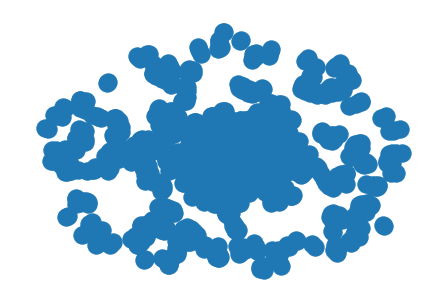

In [62]:
c=0
for component in list(nx.connected_components(G)):
    c += 1
nx.draw(G)
print('number of nodes = ,',G.number_of_nodes(),'number of edges = ,', G.number_of_edges(),'number of components = ,',c) 

In [70]:
for component in list(nx.connected_components(G)):
    c += 1
    if len(component)<70:
        for node in component:
            G.remove_node(node)

number of nodes =  719 number of edges =  803


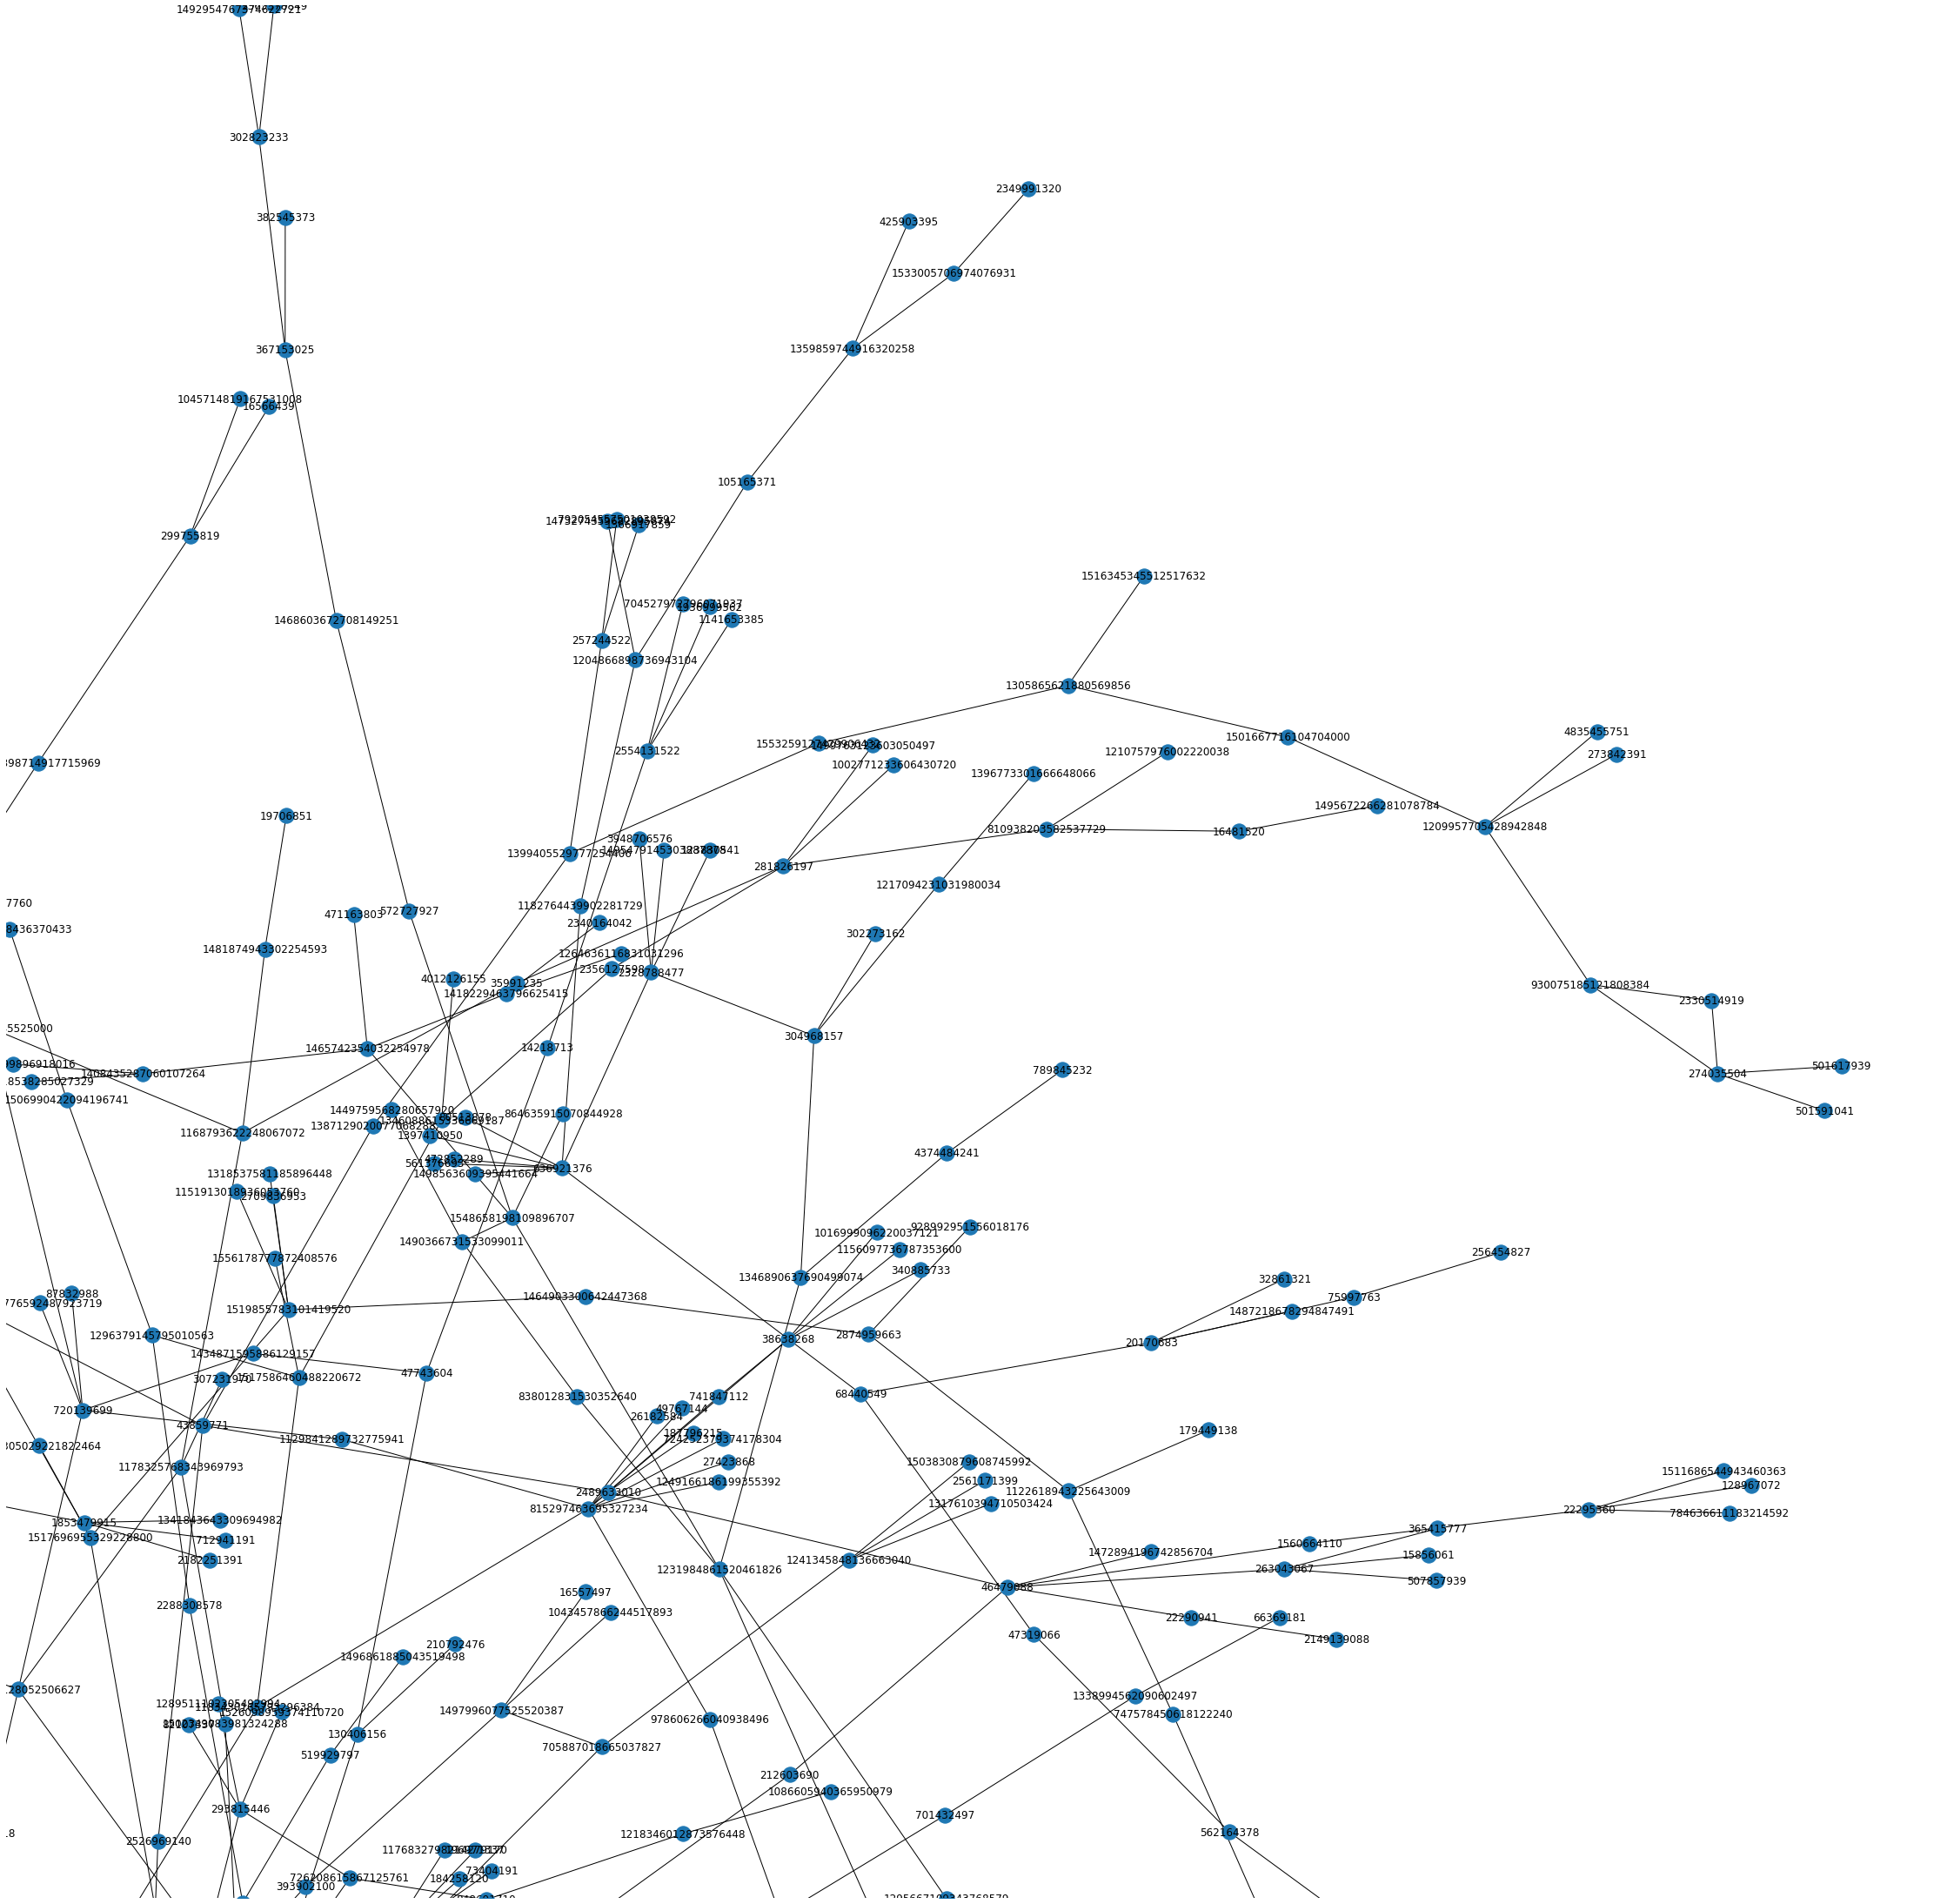

In [112]:
from matplotlib import pylab
def save_graph(graph, file_name):
    #initialze Figure
    plt.figure(num=None, figsize=(40, 40))
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph,pos)
    nx.draw_networkx_edges(graph,pos)
    nx.draw_networkx_labels(graph,pos)

    cut = 1.00
    xmax = cut * max(xx for xx, yy in pos.values())
    ymax = cut * max(yy for xx, yy in pos.values())
    plt.xlim(0, xmax)
    plt.ylim(0, ymax)
    
save_graph(G,'g')
print('number of nodes = ', G.number_of_nodes(),
     'number of edges = ', G.number_of_edges())

In [73]:
c=0
for component in list(nx.connected_components(G)):
    c += 1
print(c)

3


In [78]:
G.number_of_nodes()

719